# Description:

* Demultiplexing libraries from MiSeq run

## Setting variables (user input)

In [1]:
import os

seqdir = '/home/backup_files/raw_reads/fullcyc2.Barnett.2018/fullCyc2_lib15/run1'
workdir = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib15'

# metadata file location(s)
metadata = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/FullCyc2_master_metadata.txt'

# Library
library = 'fullCyc2_lib15'

# Index and paired files
index_read1_file = 'index_read1.fq.gz'
index_read2_file = 'index_read2.fq.gz'
read12_screed = 'pear_merged-fullCyc2_lib15.assembled.fastq_screed'


## Init

In [2]:
import os
import json
import screed
import pandas as pd
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import scipy.stats as stats
import screed
from glob import glob

In [3]:
%cd $workdir

/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib15


In [4]:
%load_ext rpy2.ipython
#%load_ext pushnote 

In [5]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


## Loading metadata tables

In [6]:
# loading metadata sheet
df_meta = pd.read_csv(os.path.join(seqdir, metadata), delimiter="\t")
df_meta.head(n=3)

,#Sample,primer_number,exp_type,extraction_plate_ID,library_ID,pool_plate_ID,pool_plate_well,soil_ID,substrate,day,...,water_holding_capacity__g.g,percent_N,percent_C,sand__perc,silt__perc,clay__perc,DNA_conc__ng_ul,notes,fwd_barcode,rev_barcode
0,EL.A.151026,129,bulk,14012016,Chantal_Pool9,NaN,NaN,EL.A.151026,NaN,NaN,...,0.778,0.20905,2.0399,40.0,26.7,33.3,19.965,NaN,CTACTATA,CGTACTCA
1,CC.M.151027.12C-Van.D02,129,Enrichment,Enr2_160509,fullCyc2_lib14,fullCyc2_lib14_pool_2,A5,CC.M.151027.12C-Van.D02,12C-Van,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,34.44,NaN,CTACTATA,CGTACTCA
2,MF.M.151026.12C-Ami.D02,129,Enrichment,Enr5_170113,fullCyc2_lib15,fullCyc2_lib15_pool_2,A5,MF.M.151026.12C-Ami.D02,12C-Ami,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,27.183,NaN,CTACTATA,CGTACTCA


In [7]:
# filter only metadata from this library
df_meta = pd.DataFrame(df_meta[df_meta.library_ID==library])
df_meta

,#Sample,primer_number,exp_type,extraction_plate_ID,library_ID,pool_plate_ID,pool_plate_well,soil_ID,substrate,day,...,water_holding_capacity__g.g,percent_N,percent_C,sand__perc,silt__perc,clay__perc,DNA_conc__ng_ul,notes,fwd_barcode,rev_barcode
2,MF.M.151026.12C-Ami.D02,129,Enrichment,Enr5_170113,fullCyc2_lib15,fullCyc2_lib15_pool_2,A5,MF.M.151026.12C-Ami.D02,12C-Ami,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,27.183,NaN,CTACTATA,CGTACTCA
15,MR.F.151027.12C-Ami.D02,130,Enrichment,Enr5_170113,fullCyc2_lib15,fullCyc2_lib15_pool_2,B5,MR.F.151027.12C-Ami.D02,12C-Ami,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,17.164,NaN,CGTTACTA,CGTACTCA
28,BH.A.151026.H2O-Con.D04,131,Enrichment,Enr5_170113,fullCyc2_lib15,fullCyc2_lib15_pool_2,C5,BH.A.151026.H2O-Con.D04,H2O-Con,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,15.454,NaN,AGAGTCAC,CGTACTCA
41,CF.A.151027.12C-Van.D02,132,Enrichment,Enr5_170113,fullCyc2_lib15,fullCyc2_lib15_pool_2,D5,CF.A.151027.12C-Van.D02,12C-Van,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.08,NaN,TACGAGAC,CGTACTCA
54,MR.M.151027.12C-Xyl.D02,133,Enrichment,Enr5_170113,fullCyc2_lib15,fullCyc2_lib15_pool_2,E5,MR.M.151027.12C-Xyl.D02,12C-Xyl,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,23.908,NaN,ACGTCTCG,CGTACTCA
67,PP.A.151026.12C-Pal.D14,134,Enrichment,Enr5_170113,fullCyc2_lib15,fullCyc2_lib15_pool_2,F5,PP.A.151026.12C-Pal.D14,12C-Pal,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.612,NaN,TCGACGAG,CGTACTCA
80,BH.M.151026.12C-Xyl.D02,135,Enrichment,Enr5_170113,fullCyc2_lib15,fullCyc2_lib15_pool_2,G5,BH.M.151026.12C-Xyl.D02,12C-Xyl,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,16.857,NaN,GATCGTGT,CGTACTCA
94,BH.F.151026.12C-Pal.D14,136,Enrichment,Enr5_170113,fullCyc2_lib15,fullCyc2_lib15_pool_2,H5,BH.F.151026.12C-Pal.D14,12C-Pal,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10.706,NaN,GTCAGATA,CGTACTCA
108,MF.M.151026.H2O-Con.D02,137,Enrichment,Enr5_170113,fullCyc2_lib15,fullCyc2_lib15_pool_2,A6,MF.M.151026.H2O-Con.D02,H2O-Con,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,28.049,NaN,CTACTATA,CTACGCAG
122,MR.A.151027.12C-Pal.D28,138,Enrichment,Enr5_170113,fullCyc2_lib15,fullCyc2_lib15_pool_2,B6,MR.A.151027.12C-Pal.D28,12C-Pal,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.097,NaN,CGTTACTA,CTACGCAG


# Uncompress index files and create screed db

In [8]:
def uncomp(fileName, directory):
    output = fileName.replace(".gz", "")
    fileName = os.path.join(directory, fileName)
    !cd $workdir; \
        pigz -k -d -p 20 -c -f $fileName > $output
    return os.path.splitext(output)[0]
    
index_read1_file = uncomp(index_read1_file, seqdir)
index_read2_file = uncomp(index_read2_file, seqdir)

In [9]:
os.chdir(workdir)
screed.read_fastq_sequences(index_read1_file+".fq")
screed.read_fastq_sequences(index_read2_file+".fq")

index_read1_screed = index_read1_file + '.fq_screed'
index_read2_screed = index_read2_file + '.fq_screed'

# Demultiplex

In [10]:
# rev-comp functions
def complement(seq): 
    idx = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N':'N'} 
    idx.update( {x.lower():y.lower() for x,y in idx.items()} )
    return ''.join(idx[x] for x in list(seq))

def revComp(seq):
    seq = seq[::-1]
    return complement(seq)    

In [11]:
# loading/editing metadata

df_meta.columns = ['Sample'] + list((df_meta.columns)[1:])

df_meta['Barcode_FR'] = [(revComp(y) + x).lower() for x,y \
                         in zip(df_meta.fwd_barcode,df_meta.rev_barcode)]


## format of barcode=>sample dict: [revBarcode=read1 + fwdBarcode=read2] : sampleID
map_d = {x:y for x,y in zip(df_meta.Barcode_FR, df_meta.Sample)}

In [15]:
# resulting dict of sample => barcode_FR 
n_print = 190

[(list(map_d.keys())[i], map_d[list(map_d.keys())[i]]) for i in range(n_print)]

[('tgagtacgctactata', 'MF.M.151026.12C-Ami.D02'),
 ('tgagtacgcgttacta', 'MR.F.151027.12C-Ami.D02'),
 ('tgagtacgagagtcac', 'BH.A.151026.H2O-Con.D04'),
 ('tgagtacgtacgagac', 'CF.A.151027.12C-Van.D02'),
 ('tgagtacgacgtctcg', 'MR.M.151027.12C-Xyl.D02'),
 ('tgagtacgtcgacgag', 'PP.A.151026.12C-Pal.D14'),
 ('tgagtacggatcgtgt', 'BH.M.151026.12C-Xyl.D02'),
 ('tgagtacggtcagata', 'BH.F.151026.12C-Pal.D14'),
 ('ctgcgtagctactata', 'MF.M.151026.H2O-Con.D02'),
 ('ctgcgtagcgttacta', 'MR.A.151027.12C-Pal.D28'),
 ('ctgcgtagagagtcac', 'PP.M.151026.12C-Van.D04'),
 ('ctgcgtagtacgagac', 'MW.M.151027.12C-Xyl.D02'),
 ('ctgcgtagacgtctcg', 'CC.A.151027.H2O-Con.D28'),
 ('ctgcgtagtcgacgag', 'SS.F.151026.12C-Cel.D28'),
 ('ctgcgtaggatcgtgt', 'CF.F.151027.12C-Van.D04'),
 ('ctgcgtaggtcagata', 'EL.A.151026.12C-Cel.D28'),
 ('tagtctccctactata', 'MF.A.151026.12C-Xyl.D02'),
 ('tagtctcccgttacta', 'CC.M.151027.12C-Ami.D02'),
 ('tagtctccagagtcac', 'PP.M.151026.12C-Xyl.D04'),
 ('tagtctcctacgagac', 'MW.A.151027.12C-Cel.D28'),


In [16]:
# loading screed databases 
ir1db = screed.ScreedDB(index_read1_screed)
ir2db = screed.ScreedDB(index_read2_screed)
amp_db = screed.ScreedDB(read12_screed)

In [ ]:
# demultiplexing: naming reads by sample

outFile = re.sub('fastq_screed', 'dmult.fastq', read12_screed)

counter = 0
unassigned = 0
cnt = Counter()
outFile = os.path.join(workdir, os.path.split(outFile)[1])
c = 0
with open(outFile, "w") as out:
    for rec in amp_db.itervalues():
        index_concat = ir1db[rec["name"]]["sequence"] + ir2db[rec["name"]]["sequence"]
        
        try:
            new_name = map_d[index_concat.lower()] + "_" + str(counter) #case sensitive
        except KeyError:
            unassigned += 1
            continue
        counter += 1
        cnt[map_d[index_concat.lower()]] += 1 #case sensitive
        s, q = rec["sequence"], rec["quality"]
        out.write("@%s orig_name=%s\n%s\n+\n%s\n"%(new_name,rec["name"],s,q))
        
        
print ("Unable to assign %s reads to samples"%unassigned)

In [19]:
# number of sequences
n_lines = !wc -l $outFile
n_lines = int(re.sub(' .+', '', n_lines[0]))
print('Number of sequences: {}'.format(n_lines/4))

Number of sequences: 12641636.0


# Stats on sequences

## Number of sequences per sample

In [20]:
# counting sequences for each sample
re_seqName = re.compile(r'_\d+ orig_name.+')

seq_cnt = dict()
with open(outFile, 'r') as fn:
    for line in fn.readlines():
        if re.search(re_seqName, line):
            sampleName = re.sub(re_seqName, '', line).rstrip().lstrip('@')
            try:
                seq_cnt[sampleName] += 1
            except KeyError:
                seq_cnt[sampleName] = 1 

In [21]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(seq_cnt, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

,Sample,seq_count
0,EL.F.151026.H2O-Con.D14,56501
1,SS.F.151026.H2O-Con.D14,155516
2,MW.M.151027.12C-Xyl.D02,52247
3,PP.A.151026.H2O-Con.D14,32275
4,MP.A.151026.12C-Ami.D02,67543
5,EL.A.151026.12C-Van.D02,82632
6,MP.A.151026.12C-Xyl.D02,89571
7,MF.M.151026.12C-Xyl.D02,53917
8,MP.F.151026.12C-Van.D04,65169
9,MW.A.151027.H2O-Con.D02,28151


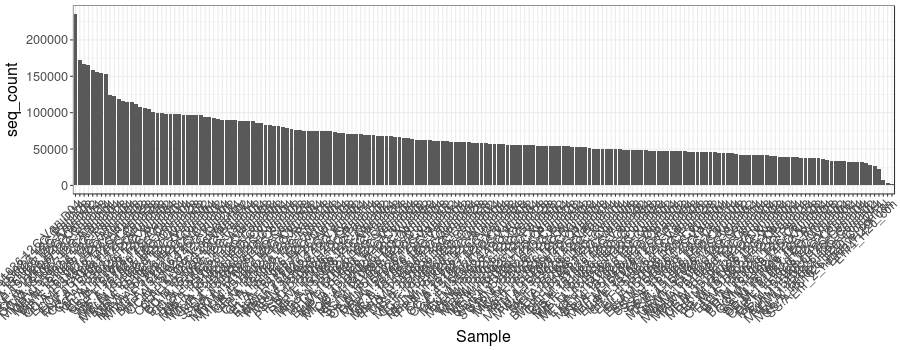

In [22]:
%%R -i df_seq_cnt -w 900 -h 350

df_seq_cnt$Sample = reorder(df_seq_cnt$Sample, desc(df_seq_cnt$seq_count))

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [25]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 20000,]

                    Sample seq_count
187           Enr3_H2O_con      3556
188 Enr_2_negative_control      6825
189           Enr4_H20_con      1869


### Are the number of samples returned the same as expected?

In [24]:
print ("You got " + str(len(df_seq_cnt)) + " samples")
print ("You should have " + str(len(df_meta)) + " samples")


You got 190 samples
You should have 190 samples
